# Predicting an Activity of Mine

Author: Jeffrey Pham

Course Project, UC Irvine, Math 10, S22

## Introduction

The dataset provided is my own personal recorded data of activities I have done within the years 2020-2021 rounded to the nearest hour. This project will explore if an activity of mine can be predicted through machine learning and see how accurate it is.

## Organization of Data

In [ ]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
df_wide = pd.read_csv("Compiled 2020-2021 Data.csv")
df_wide = df_wide.rename(columns={"Unnamed: 0":"Date"})
df_wide["Date"] = pd.to_datetime(df_wide["Date"])
# 1st version of my dataset has the timeframe as the columns
df_wide.head()

,Date,0:00-0:59,1:00-1:59,2:00-2:59,3:00-3:59,4:00-4:59,5:00-5:59,6:00-6:59,7:00-7:59,8:00-8:59,...,14:00-14:59,15:00-15:59,16:00-16:59,17:00-17:59,18:00-18:59,19:00-19:59,20:00-20:59,21:00-21:59,22:00-22:59,23:00-23:59
0,2020-01-01,Social,Social,Social,Social,Sleep,Sleep,Sleep,Sleep,Sleep,...,Unproductive,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming
1,2020-01-02,Anime/Manga,Anime/Manga,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,...,Gaming,Gaming,Gaming,Anime/Manga,Anime/Manga,Anime/Manga,Anime/Manga,Anime/Manga,Anime/Manga,Anime/Manga
2,2020-01-03,Anime/Manga,Anime/Manga,Anime/Manga,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,...,Gaming,Unproductive,Unproductive,Downtime,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming
3,2020-01-04,Social,Social,Social,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,...,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming
4,2020-01-05,Anime/Manga,Anime/Manga,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,...,Work,Gaming,Gaming,Gaming,Gaming,Gaming,Social,Anime/Manga,Anime/Manga,Anime/Manga


In [ ]:
df = pd.read_csv("Compiled Edit.csv")
# 2nd version of my dataset has the date as the columns that I edited in excel
df.head()

,Date,01/01/2020,01/02/2020,01/03/2020,01/04/2020,01/05/2020,01/06/2020,01/07/2020,01/08/2020,01/09/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,0:00,Social,Anime/Manga,Anime/Manga,Social,Anime/Manga,Anime/Manga,Anime/Manga,Sleep,Sleep,...,Sleep,Internet,Twitch/YT,Anime/Manga,Twitch/YT,Anime/Manga,Sleep,Sleep,Gaming,Gaming
1,1:00,Social,Anime/Manga,Anime/Manga,Social,Anime/Manga,Sleep,Sleep,Sleep,Sleep,...,Sleep,Anime/Manga,Sleep,Anime/Manga,Sleep,Anime/Manga,Sleep,Sleep,Gaming,Gaming
2,2:00,Social,Sleep,Anime/Manga,Social,Sleep,Sleep,Sleep,Sleep,Sleep,...,Sleep,Anime/Manga,Sleep,Anime/Manga,Sleep,Sleep,Sleep,Sleep,Gaming,Gaming
3,3:00,Social,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,...,Sleep,Social,Sleep,Anime/Manga,Sleep,Sleep,Sleep,Sleep,Gaming,Gaming
4,4:00,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,...,Sleep,Social,Sleep,Sleep,Sleep,Sleep,Sleep,Sleep,Gaming,Gaming


In [ ]:
df = df.melt(id_vars="Date")

In [ ]:
# Here I reorganize my data to go from wideform to longform
df = df.reindex(columns=["variable","Date","value"])
df["Date"] = pd.to_datetime(df["variable"] + ' ' + df["Date"])
df = df.rename(columns={"value":"Activity"})
df = df.drop(["variable"],axis=1)

In [ ]:
# Hot encoding my activites and saving to a separate dataframe for later
df_dummy = pd.get_dummies(df)
activity = [i for i in df_dummy.columns if i != "Date"]
df_dummy = df_dummy.drop(["Date"],axis=1)

In [ ]:
# Here I assign values to each day so they are grouped better
df["Time"] = df["Date"].dt.hour
df["Day"] = df["Date"].dt.weekday
df["Month"] = df["Date"].dt.month
timeframe = ["Time","Day","Month"]

df.head()

,Date,Activity,Time,Day,Month
0,2020-01-01 00:00:00,Social,0,2,1
1,2020-01-01 01:00:00,Social,1,2,1
2,2020-01-01 02:00:00,Social,2,2,1
3,2020-01-01 03:00:00,Social,3,2,1
4,2020-01-01 04:00:00,Sleep,4,2,1


In [ ]:
df2 = pd.concat([df, df_dummy], axis=1)
df2["Day Name"] = df2["Date"].dt.day_name()

An altair chart is used to display the data before predicting. Some activites are explained below:
* Anime/Manga: Time spent watching anime or reading manga
* Downtime: Time spent doing miscellaneous activities such as eating, showering, chores, etc.
* Internet: Time spent web surfing
* Traffic: Time spent commuting or travelling
* Twitch/YT: Time spent watching videos whether that be on twitch, youtube, or other platforms even movies.

In [ ]:
alt.data_transformers.enable('default', max_rows=20000)

DataTransformerRegistry.enable('default')

In [ ]:
brush = alt.selection_interval()
c1 = alt.Chart(df).mark_square().encode(
    x="Time",
    y="Date",
    color= alt.Color("Activity", scale=alt.Scale(scheme="turbo")),
    tooltip = ["Activity","Date"]
).properties(
    title="Hours logged",
    height=600,
    width=300
).add_selection(brush)
c2 = alt.Chart(df).mark_bar().encode(
    x="Activity",
    y="Date"
    #color= alt.Color("Activity", scale=alt.Scale(scheme="turbo")),
    #tooltip = ["Activity","Date"]
).properties(
    width=200
).transform_filter(brush)

c1|c2

alt.HConcatChart(...)

## Predicting an Activity at Time Intervals

I will first use a decision tree to see if I can predict a general activity at certain times.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[timeframe], df["Activity"], train_size=0.8, random_state=0)

A training set is created on the overall time intervals with the target on activities using.

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=8,max_leaf_nodes=25)
clf_tree.fit(X_train,y_train)
score_train = clf_tree.score(X_train, y_train)
score_test = clf_tree.score(X_test, y_test)
#loss_train = log_loss(y_train, clf_tree.predict_proba(X_train))
#loss_test = log_loss(y_test, clf_tree.predict_proba(X_test))

In [ ]:
print(f"Accuracy of the training data: {score_train}")
print(f"Accuracy of the test data: {score_test}")

Accuracy of the training data: 0.48820805130032063
Accuracy of the test data: 0.4927329723567968


In [ ]:
(y_train == clf_tree.predict(X_train)).value_counts()

False    7183
True     6852
Name: Activity, dtype: int64

Despite the scores being very close to each other suggesting that we probably don't have to worry about overfitting, it was only able to predict less than half of the true values.

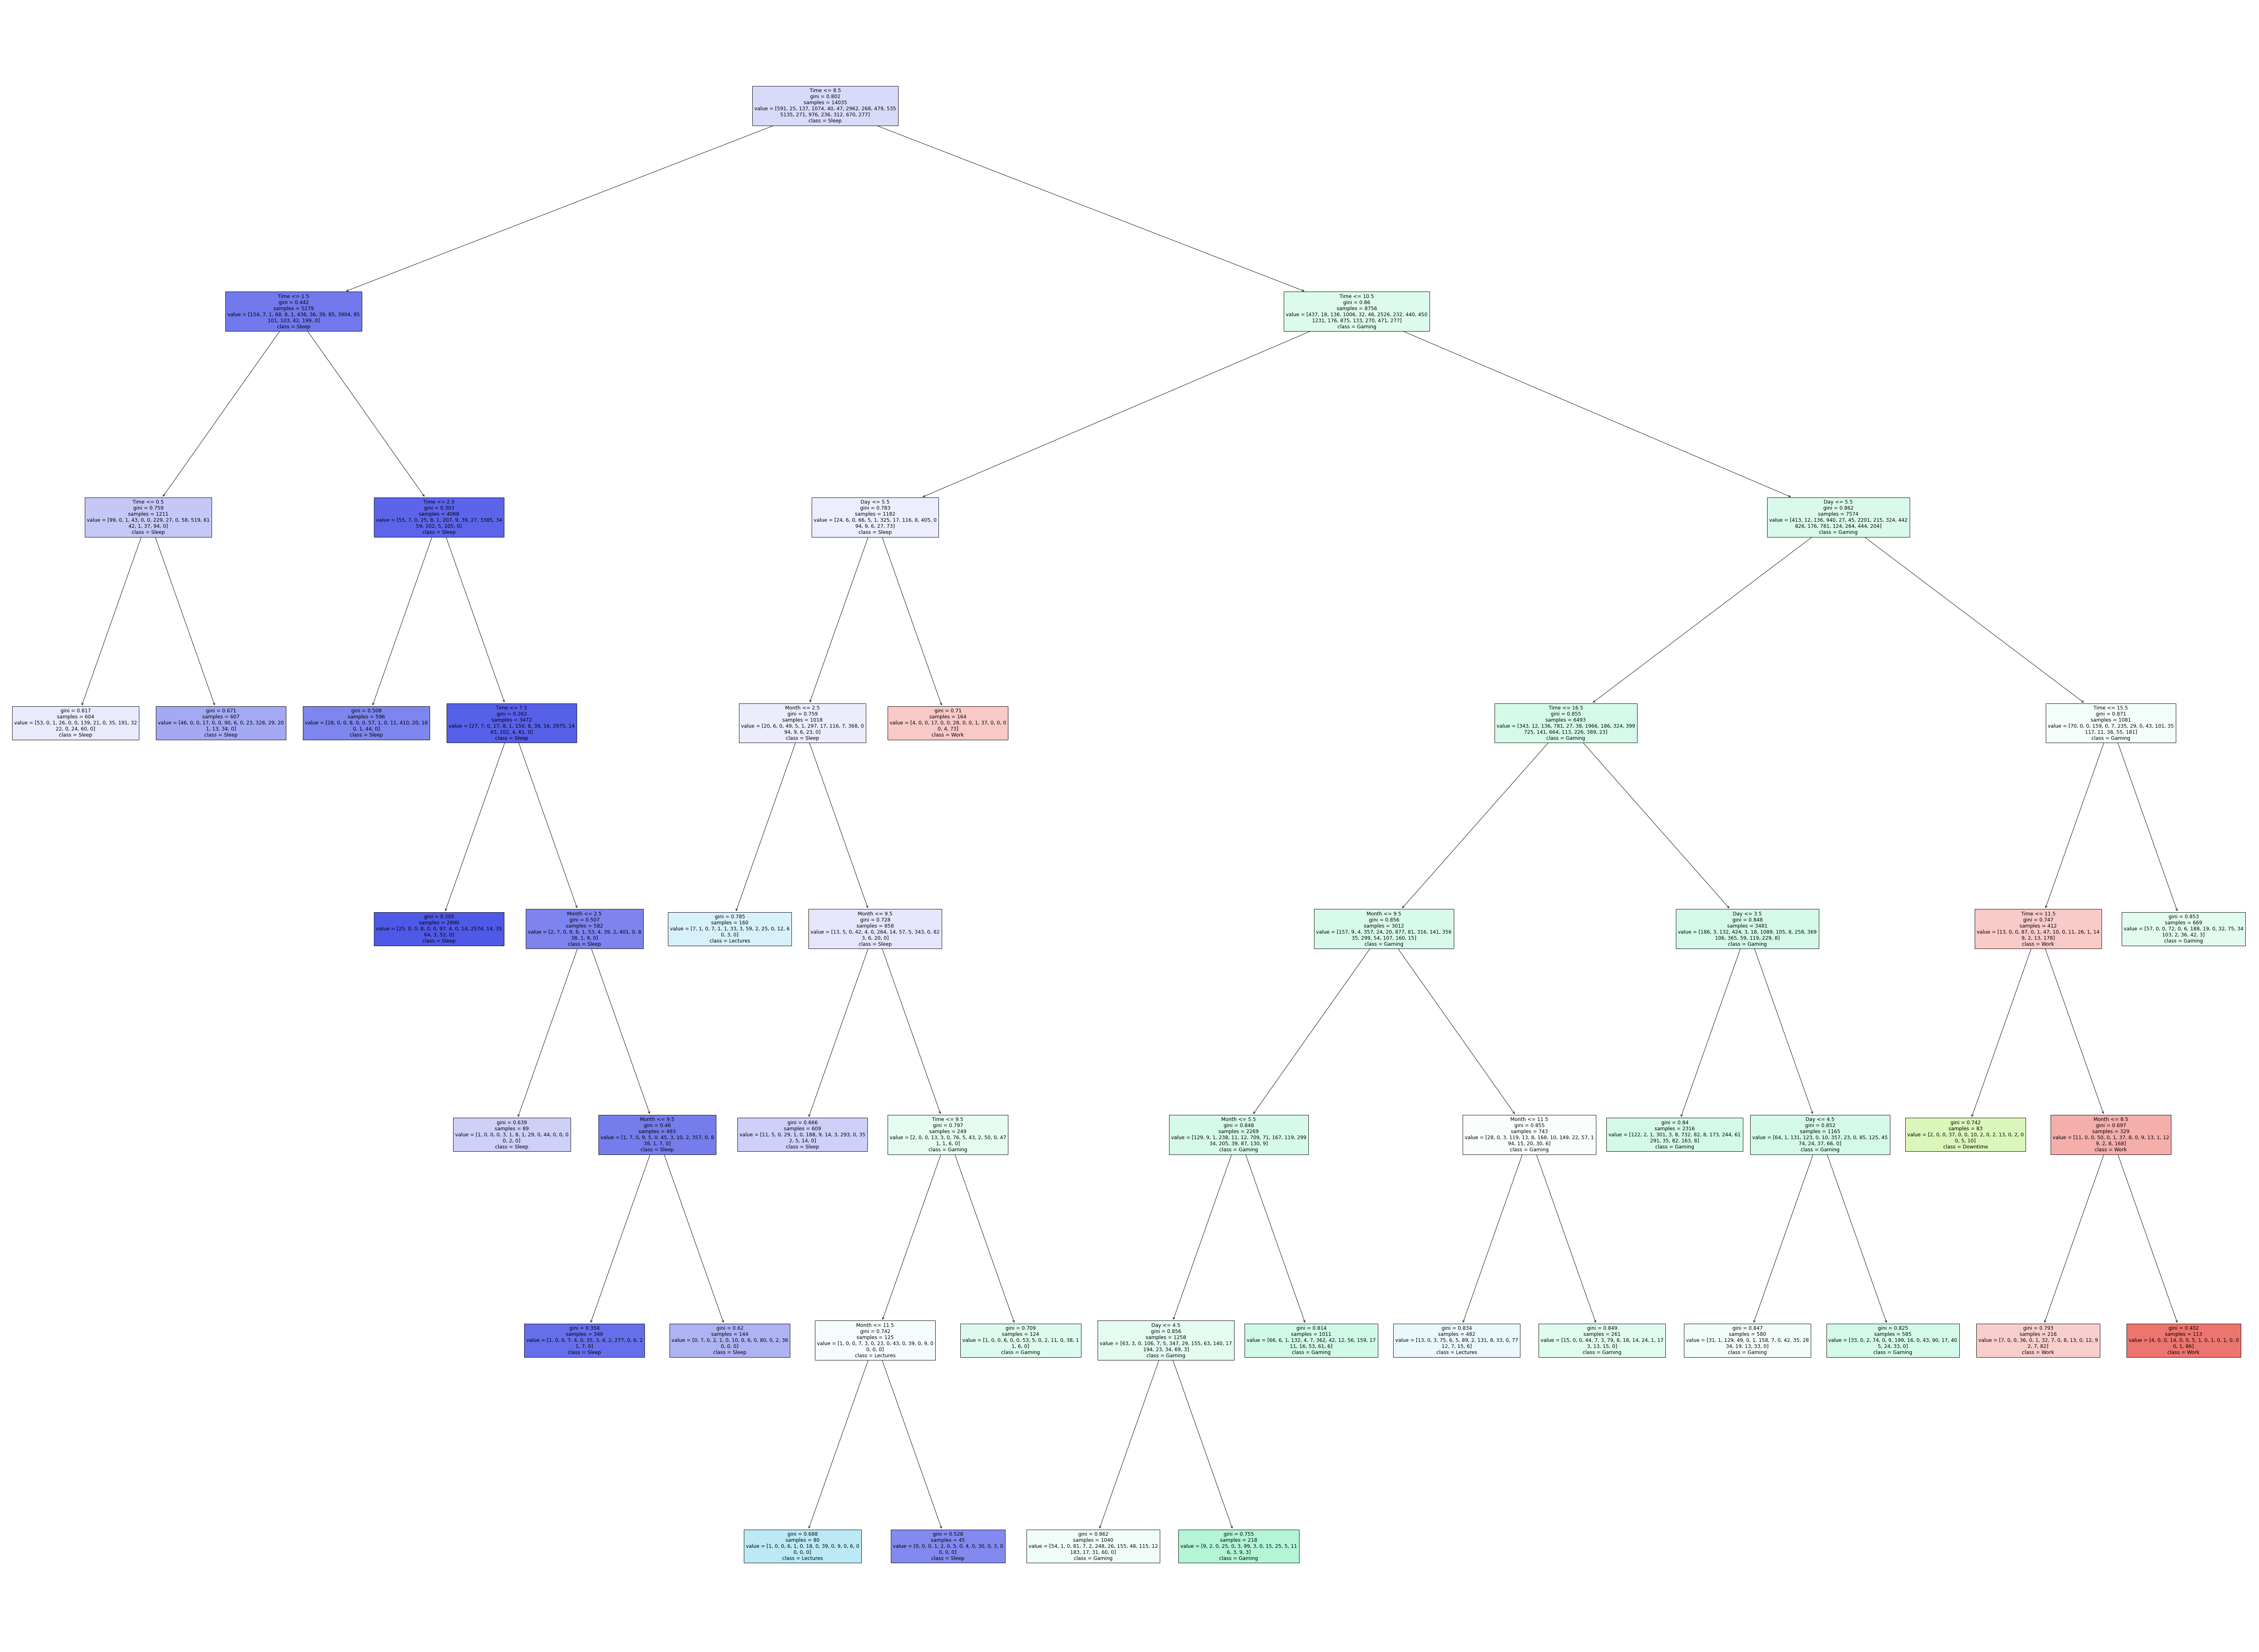

In [ ]:
fig = plt.figure(figsize=(100,75))
_ = tree.plot_tree(clf_tree, 
                   feature_names=clf_tree.feature_names_in_,  
                   class_names=clf_tree.classes_,
                   filled=True)

The decision tree displayed here allows us to accurately follow a certain activity at a very close timeframe. On the far right for example, I am usually working on weekends between 11-15 or 11:00 AM to 3:00 PM.

## Predicting the Day of the Week

I will now look and see if machine learning can predict a day of the week given several different activities using Logistic Regression.

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2[activity], df2["Day Name"], train_size=0.8, random_state=0)

Another training set is created on the overall activites this time with the target being the day of the week.

In [ ]:
clf_log = LogisticRegression()
clf_log.fit(X_train2, y_train2)
df_train = pd.DataFrame()
df_train["Day"] = y_test2
df_train["Pred"] = clf_log.predict(X_test2)
score_train2 = clf_log.score(X_train2, y_train2)
score_test2 = clf_log.score(X_test2, y_test2)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(f"Accuracy of the training data: {score_train2}")
print(f"Accuracy of the test data: {score_test2}")

Accuracy of the training data: 0.20071250445315283
Accuracy of the test data: 0.19378740381875179


The accuracy is much lower this time but still doesn't seem like there's overfitting siince the scores are very close.

In [ ]:
alt.data_transformers.enable('default', max_rows=15000)

c = alt.Chart(df_train).mark_rect().encode(
    x="Day",
    y="Pred",
    color= alt.Color("count()", scale=alt.Scale(scheme="turbo"))
)

c_text = alt.Chart(df_train).mark_text(color="white").encode(
    x="Day",
    y="Pred",
    text="count()"
)

(c+c_text).properties(
    height=400,
    width=400
)

alt.LayerChart(...)

This altair chart is a better visualization of how accurate the prediction was where the diagonal is what was predicted correctly while everything else is wrong. Saturdays were predicted the most probably because it is the day I have the most free time so I could be doing a variety of things every weekend.

## Summary

In this project I was only able to predict the correct activity at a specific date about half of the times. Even though the accuracy of the predictions are low standing at 45%, the training and test data are really close in their values so overfitting is probably not an issue. The results are similar when trying to predict the days as well where the scores are low at 20% but the training and test results are very close so overfitting isn't really an issue of the scores. Perhaps a dataset with less activites that is less cluttered could provide more accurate results.

## References

* Source of my data: https://docs.google.com/spreadsheets/d/1IGerErIFy2Hoy9vZa1dVP9JqpEcUzEwKVfSvfqmna8c/edit?usp=sharing

* Altair chart for logistic regression similar to the mnist chart used in HW6: https://christopherdavisuci.github.io/UCI-Math-10-S22/Week7/Homework6.html

* Decision tree code: https://christopherdavisuci.github.io/UCI-Math-10-S22/Week9/Week9-Tuesday.html

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0dffbae-d0f2-4629-bf2e-3fe1a50cad4b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>